In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.stats import zscore, circvar

# Predict steering based on head direction, goal phase, and PFL scaling factor, with different nonlinearity options

## Functions

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def linear_rescale(activity, new_min, new_max):

    rescaled = np.interp(activity, (np.min(activity), np.max(activity)), (new_min, new_max))
    
    return rescaled


def wrap_to_180(angles):

    if isinstance(angles, list):
        angles = np.asarray(angles)
        
    angles = np.rad2deg(np.arctan2(np.sin(np.deg2rad(angles)), np.cos(np.deg2rad(angles))))
    
    return angles

def circ_dist(x, y):

    circular_distance = np.angle(np.exp(1j*x)/np.exp(1j*y))
    return circular_distance

def ELU1(activity):

    activity_shape = activity.shape
    scaled_activity = np.zeros(activity_shape)
    nonlinear_activity = np.zeros(activity_shape)

    scaled_activity = linear_rescale(activity, -1.0, 1.0)
    
    for p in range(activity_shape[0]):
        for s in range(activity_shape[1]):
            nonlinear_activity[p, s] = scaled_activity[p, s]*(scaled_activity[p, s] >=  0)  +  (np.exp(scaled_activity[p, s])  -  1)*(scaled_activity[p, s] < 0)

    nonlinear_activity = linear_rescale(nonlinear_activity, 0.0, 1.0)

    return nonlinear_activity

def ELU2(activity):

    activity_shape = activity.shape
    scaled_activity = np.zeros(activity_shape)
    nonlinear_activity = np.zeros(activity_shape)

    scaled_activity = linear_rescale(activity, -1.0, 1.0)

    for p in range(activity_shape[0]):
        for s in range(activity_shape[1]):

            nonlinear_activity[p,s] = 4*scaled_activity[p,s]*(scaled_activity[p,s] >=  0)  +  (np.exp(4*scaled_activity[p,s])  -  1)*(scaled_activity[p,s] < 0)

    nonlinear_activity = linear_rescale(nonlinear_activity, 0.0, 1.0)

    return nonlinear_activity


def ReLU(activity):

    activity_shape = activity.shape
    scaled_activity = np.zeros(activity_shape)
    nonlinear_activity = np.zeros(activity_shape)
    scaled_activity = linear_rescale(activity, -1.0, 1.0)

    for p in range(activity_shape[0]):
        for s in range(activity_shape[1]):

            nonlinear_activity[p,s] = np.max(scaled_activity, 0)

    nonlinear_activity = linear_rescale(nonlinear_activity, 0.0, 1.0)

    return nonlinear_activity

def LeakyReLU(activity):

    activity_shape = activity.shape
    scaled_activity = np.zeros(activity_shape)
    nonlinear_activity = np.zeros(activity_shape)
    scaled_activity = linear_rescale(activity, -1.0, 1.0)

    for p in range(activity_shape[0]):
        for s in range(activity_shape[1]):

            nonlinear_activity[p,s][scaled_activity[p,s] < 0] = 0.5*scaled_activity[p,s][scaled_activity[p,s] < 0]

    nonlinear_activity = linear_rescale(nonlinear_activity, 0.0, 1.0)
    return nonlinear_activity

def Sigmoid(activity):

    activity_shape = activity.shape
    scaled_activity = np.zeros(activity_shape)
    nonlinear_activity = np.zeros(activity_shape)
    scaled_activity = linear_rescale(activity, -1.0, 1.0)


    for p in range(activity_shape[0]):
        for s in range(activity_shape[1]):

            nonlinear_activity[p,s] = 1./(1 + np.exp(- 2.5 * (scaled_activity[p,s]  -  0.2)))

    nonlinear_activity = linear_rescale(nonlinear_activity, 0.0, 1.0)
    return nonlinear_activity

                                                                                                                                      
def nonlinearity(activity):

    if nonlinearity_option == 'ELU1':
        return ELU1(activity)
    
    elif nonlinearity_option == 'ELU2':
        return ELU2(activity)
    
    elif nonlinearity_option == 'Sigmoid':
        return Sigmoid(activity)
    
    elif nonlinearity_option == 'LeakyReLU':
        return LeakyReLU(activity)
        
    elif nonlinearity_option == 'ReLU':
        return ReLU(activity)

    else:
        return activity

## Definite initial values and connectivities

In [3]:
"""Predict steering based on head direction, goal phase, and PFL scaling factor, with different nonlinearity options

Keyword arguments:
connectivity_option: {'data', 'abstract'}, default: 'abstract'
    Determines the connectivity information used for the model
    -- abstract: simplified weights with arbitrary number of cells
    -- data: hemibrain connectome with real cell numbers

nonlinearity_option: {'ELU1', 'ELU2', 'Sigmoid', 'LeakyReLU', 'ReLU', 'None'}, default: 'ELU1'

pfl3_inhibitory_option: bool, default: 'false'
    -- true: PFL3 cells are excitatory
    -- false: PFL3 cells are inhibitory

pfl2_silenced_option: bool, default: 'false'
    -- true: PFL2 activity is set equal to zero
    -- false: PFL2 activity is not silenced

"""

connectivity_option = 'abstract'
nonlinearity_option = 'ELU1'
pfl3_inhibitory_option = False
pfl2_silenced_option = False

# goal amplitude
A = 1 

# Alternative values of goal phase, in units of degrees, bounded by [-180 180]
goal_phase = np.arange(-180, 181, 10)

# Number of head directions tested
num_goals = len(goal_phase)

# Possible values of head direction (HD), in units of degrees
hd_deg_open_loop = np.arange(-180, 181, 1)
hd_deg_open_loop = hd_deg_open_loop.reshape(1, len(hd_deg_open_loop))

# Number of head directions tested
num_HD = max(hd_deg_open_loop.shape)

# Arbitrary value of neural "bump position" at HD = 0, in units of degrees
offset_deg = 0

# Number of scalar values to test; use 6 if sampling sparsely and 60 if sampling densely
num_scalars = 6

# Scalar values are in the range [0,1]; these values are used to scale the inputs to PFL cells
S_vals = np.linspace(0, 1, num_scalars, endpoint = True)

if connectivity_option == 'abstract':

    # number of "cells" per cell type; set to 1000 for quasi-continuous (smooth) output functions
    num_cells = 1000

    # Create a list of the preferred HD value for each cell, centered on 0
    hd_prefs_uncentered = np.linspace(0, 360, num_cells, endpoint = False)
    hd_prefs = np.flip((hd_prefs_uncentered - np.mean(hd_prefs_uncentered)).reshape(1, len(hd_prefs_uncentered)))

    # Initialize pfl2, pfl3r, and pfl3l activity
    pfl2 = np.zeros((num_goals, num_scalars, num_HD, num_cells))
    pfl3r = np.zeros((num_goals, num_scalars, num_HD, num_cells))
    pfl3l = np.zeros((num_goals, num_scalars, num_HD, num_cells))

    # pfl2-to-dna03 connections are about 4x stronger than pfl3-to-dna03 connections
    w_pfl2_dna03r = 4 * np.ones((1, num_cells)) 
    w_pfl2_dna03l = 4 * np.ones((1, num_cells))

    # pfl3-to-dna03 connections are assigned weight 1,  arbitrarily
    w_pfl3r_dna03r = np.ones((1, num_cells)) 
    w_pfl3l_dna03l = np.ones((1, num_cells))

    # pfl3-to-dna02 connections are similar in strength to pfl3-to-dna03 connections
    w_pfl3r_dna02r = np.ones((1, num_cells)) 
    w_pfl3l_dna02l = np.ones((1, num_cells))

    # dna03-to-dna02 connections are about 12x stronger than pfl3-to-dna02 connections
    w_dna03r_dna02r = 12
    w_dna03l_dna02l = 12

elif connectivity_option == 'data':

    # 12 cells per cell type
    num_cells = 12

    # predicted HD preferences for PFL2 cells with dendrites in PB glomeruli L5,L4,L3,L3,L2,L1,R1,R2,R3,R3,R4,R5
    pfl2_HD_prefs = [0, -45, -90, -90, -135, 180, 180, 135, 90, 90, 45, 0]

    # predicted HD preferences for PFL3R cells with dendrites in PB glomeruli L7,L6,L5,L5,L4,L3,L3,L2,L1,L1,R1,R2
    pfl3r_HD_prefs = [90, 45, 0, 0, -45, -90, -90, -135, 180, 180, 180, 135]
    
    # predicted HD preferences for PFL3L cells with dendrites in PB glomeruli L2,L1,R1,R1,R2,R3,R3,R4,R5,R5,R6,R7
    pfl3l_HD_prefs = [-135, 180, 180, 180, 135, 90, 90, 45, 0, 0, -45, -90]

    # Initialize pfl2, pfl3r, and pfl3l activity
    pfl2 = np.zeros((num_goals, num_scalars, num_HD, num_cells))
    pfl3r = np.zeros((num_goals, num_scalars, num_HD, num_cells))
    pfl3l = np.zeros((num_goals, num_scalars, num_HD, num_cells))

    # HD preferences of the 12 cells in the goal cell population, centered on 0, listed left-to-right
    hd_prefs = [165, 135, 105, 75, 45, 15, -15, -45, -75, -105, -135, -165]

    # data from hemibrain connectome, with PFL2 cells indexed from L5 through R5
    # assume left-right symmetry in connection weights
    w_pfl2_dna03r = np.asarray([ 1., 72., 56., 57., 96., 57., 54., 79., 45., 58., 89., 76.]).reshape(1, num_cells)
    w_pfl2_dna03l = np.flip(w_pfl2_dna03r)

    # data from hemibrain connectome, with PFL3 cells indexed from L7 through R2
    # assume left-right symmetry in connection weights
    w_pfl3r_dna03r = np.asarray([25., 28.,  8., 13., 26., 29., 12.,  1.,  9., 22.,  1., 26.]).reshape(1, num_cells)
    w_pfl3l_dna03l = np.flip(w_pfl3r_dna03r)

    # data from hemibrain connectome
    # assume left-right symmetry in connection weights
    w_pfl3r_dna02r = np.asarray([21., 25., 17., 14., 19., 44., 25., 25.,  7., 11.,  3., 39.]).reshape(1, num_cells)
    w_pfl3l_dna02l = np.flip(w_pfl3r_dna02r)

    # data from hemibrain connectome, assume left-right symmetry in connection weights
    w_dna03r_dna02r = 271 
    w_dna03l_dna02l = 271
    
# Arrange weights into matrices
w_pfl2_dna03r = np.tile(w_pfl2_dna03r.T, (num_scalars, num_goals, 1, num_HD))
w_pfl2_dna03r = np.moveaxis(w_pfl2_dna03r, (0, 1, 2, 3), (1, 0, 3, 2))

w_pfl2_dna03l = np.tile(w_pfl2_dna03l.T, (num_scalars, num_goals, 1, num_HD))
w_pfl2_dna03l = np.moveaxis(w_pfl2_dna03l, (0, 1, 2, 3), (1, 0, 3, 2))

w_pfl3r_dna03r = np.tile(w_pfl3r_dna03r.T, (num_scalars, num_goals, 1, num_HD))
w_pfl3r_dna03r = np.moveaxis(w_pfl3r_dna03r, (0, 1, 2, 3), (1, 0, 3, 2))

w_pfl3l_dna03l = np.tile(w_pfl3l_dna03l.T, (num_scalars, num_goals, 1, num_HD))
w_pfl3l_dna03l = np.moveaxis(w_pfl3l_dna03l, (0, 1, 2, 3), (1, 0, 3, 2))

w_pfl3r_dna02r = np.tile(w_pfl3r_dna02r.T, (num_scalars, num_goals, 1, num_HD))
w_pfl3r_dna02r = np.moveaxis(w_pfl3r_dna02r, (0, 1, 2, 3), (1, 0, 3, 2))

w_pfl3l_dna02l = np.tile(w_pfl3l_dna02l.T, (num_scalars, num_goals, 1, num_HD))
w_pfl3l_dna02l = np.moveaxis(w_pfl3l_dna02l, (0, 1, 2, 3), (1, 0, 3, 2))

w_dna03r_dna02r = w_dna03r_dna02r*np.ones((num_goals, num_scalars, num_HD))
w_dna03l_dna02l = w_dna03l_dna02l*np.ones((num_goals, num_scalars, num_HD))

if connectivity_option == 'abstract':
    pfl2_HD_input = np.cos(np.deg2rad(np.tile(hd_deg_open_loop.T, (1, len(hd_prefs))) - hd_prefs + 180 - offset_deg))
    pfl3r_HD_input = np.cos(np.deg2rad(np.tile(hd_deg_open_loop.T, (1, len(hd_prefs))) - hd_prefs + 67.5 - offset_deg))
    pfl3l_HD_input = np.cos(np.deg2rad(np.tile(hd_deg_open_loop.T, (1, len(hd_prefs))) - hd_prefs - 67.5 - offset_deg))

if connectivity_option == 'data':
    pfl2_HD_input = np.cos(np.deg2rad(np.tile(hd_deg_open_loop.T, (1, len(hd_prefs))) - pfl2_HD_prefs - offset_deg))
    pfl3r_HD_input = np.cos(np.deg2rad(np.tile(hd_deg_open_loop.T, (1, len(hd_prefs))) - pfl3r_HD_prefs - offset_deg))
    pfl3l_HD_input = np.cos(np.deg2rad(np.tile(hd_deg_open_loop.T, (1, len(hd_prefs))) - pfl3l_HD_prefs - offset_deg))

# get preferred HD of each cell
if connectivity_option == 'abstract':
    pfl2_HD_prefs = np.zeros((1, num_cells))
    pfl3r_HD_prefs = np.zeros((1, num_cells))
    pfl3l_HD_prefs = np.zeros((1, num_cells))

    # Use the peak as the preferred direction
    for n in range(num_cells):
        pfl2_HD_prefs[0, n] = hd_deg_open_loop[:, np.argmax(pfl2_HD_input[:, n])]
        pfl3r_HD_prefs[0, n] = hd_deg_open_loop[:, np.argmax(pfl3r_HD_input[:, n])]
        pfl3l_HD_prefs[0, n] = hd_deg_open_loop[:, np.argmax(pfl3l_HD_input[:, n])]
        
    # convert to integers
    pfl2_HD_prefs = np.round(pfl2_HD_prefs, 0) 
    pfl3r_HD_prefs = np.round(pfl3r_HD_prefs, 0)
    pfl3l_HD_prefs = np.round(pfl3l_HD_prefs, 0)



## Compute activity of PFL2, PFL3R, and PFL3L neurons

In [4]:
# iterate through different values of goal_phase
for p, P in enumerate(goal_phase):
    for s, S in enumerate(S_vals):
        goal_cells = A * (np.cos(np.deg2rad( -1*hd_prefs + P - offset_deg))) # generate goal neuron output
        goal_cells_rep = np.tile(goal_cells, (num_HD, 1)) # output of goal neurons is the same for all values of HD
        pfl2[p,s] = S*(pfl2_HD_input + goal_cells_rep) # add HD input and goal input and then scale these combined inputs
        pfl3r[p,s] = S*(pfl3r_HD_input + goal_cells_rep)
        pfl3l[p,s] = S*(pfl3l_HD_input + goal_cells_rep)

# Compute neural activity
pfl2 = nonlinearity(pfl2)
pfl3r = nonlinearity(pfl3r)
pfl3l = nonlinearity(pfl3l)

if pfl3_inhibitory_option:
    pfl3r = - pfl3r
    pfl3l = - pfl3l

if pfl2_silenced_option:
    pfl2 = np.zeros(pfl2.shape)

Dna03r = np.sum(w_pfl3r_dna03r*pfl3r + w_pfl2_dna03r*pfl2, axis = 3)
Dna03l = np.sum(w_pfl3l_dna03l*pfl3l + w_pfl2_dna03l*pfl2, axis = 3)
Dna03r = nonlinearity(Dna03r)
Dna03l = nonlinearity(Dna03l)

Dna02r = np.sum(np.moveaxis(np.tile(w_dna03r_dna02r*Dna03r, (1000, 1, 1, 1)), 0, 3) + w_pfl3r_dna02r*pfl3r, axis = 3)
Dna02l = np.sum(np.moveaxis(np.tile(w_dna03l_dna02l*Dna03l, (1000, 1, 1, 1)), 0, 3) + w_pfl3l_dna02l*pfl3l, axis = 3)
Dna02r = nonlinearity(Dna02r)
Dna02l = nonlinearity(Dna02l)

# model variant with direct pathway only
Dna02r_direct_only = np.sum((w_pfl3r_dna02r*pfl3r), axis = 3) # Check that this summing is across the intended axis
Dna02l_direct_only = np.sum((w_pfl3l_dna02l*pfl3l), axis = 3)
Dna02r_direct_only = nonlinearity(Dna02r_direct_only)
Dna02l_direct_only = nonlinearity(Dna02l_direct_only)

# model variant with indirect pathway only
Dna02r_indirect_only = w_dna03r_dna02r*Dna03r # Check that this summing is across the intended axis
Dna02l_indirect_only = w_dna03l_dna02l*Dna03l
Dna02r_indirect_only = nonlinearity(Dna02r_indirect_only)
Dna02l_indirect_only = nonlinearity(Dna02l_indirect_only)

pfl3_RL_diff = np.sum(pfl3r, axis = 3) - np.sum(pfl3l, axis = 3) # np.sum(pfl3r) - np.sum(pfl3l), for all values of goal phase, goal amplitude, and HD
pfl2_sum = np.sum(pfl2, axis = 3)
pfl2_bump_amp = np.max(pfl2, axis = 3) - np.min(pfl2, axis = 3)

steering = Dna02r - Dna02l # generate steering commands
steering_direct = Dna02r_direct_only - Dna02l_direct_only
steering_indirect = Dna02r_indirect_only - Dna02l_indirect_only

steering = steering/np.max(steering) # normalize to the max for all values of goal phase, goal amplitude, and HD
steering_direct = steering_direct/np.max(steering_direct)
steering_indirect = steering_indirect/np.max(steering_indirect)

## Results

### PFL3 right - left difference vs rotational velocity (Figure 2)

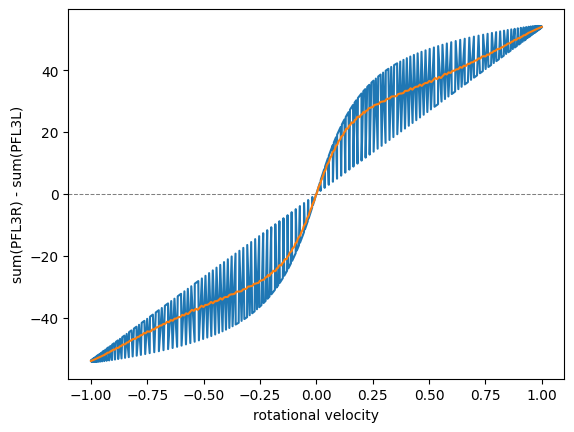

In [5]:
squeezed_hd_deg_open_loop = np.squeeze(hd_deg_open_loop)
squeezed_steering = np.squeeze(steering[goal_phase==0,S_vals==1, :])
sorted_steering_index = np.argsort(squeezed_steering)
sorted_steering = squeezed_steering[sorted_steering_index]

squeezed_pfl3_RL_diff = np.squeeze(pfl3_RL_diff[goal_phase==0, S_vals==1, :])
sorted_PFL3diff = squeezed_pfl3_RL_diff[sorted_steering_index]

sorted_steering_smoothed = savgol_filter(sorted_steering, 51, 3) # window size 51, polynomial order 3
sorted_PFL3diff_smoothed = savgol_filter(sorted_PFL3diff, 51, 3)

plt.figure()
plt.plot(sorted_steering, sorted_PFL3diff)

plt.ylabel('sum(PFL3R) - sum(PFL3L)')
plt.xlabel('rotational velocity')
plt.axhline(0, linestyle = '--', linewidth = 0.75, color = 'gray')
plt.plot(sorted_steering_smoothed, sorted_PFL3diff_smoothed)

plt.show()

### PFL2 bump amplitude vs rotational velocity

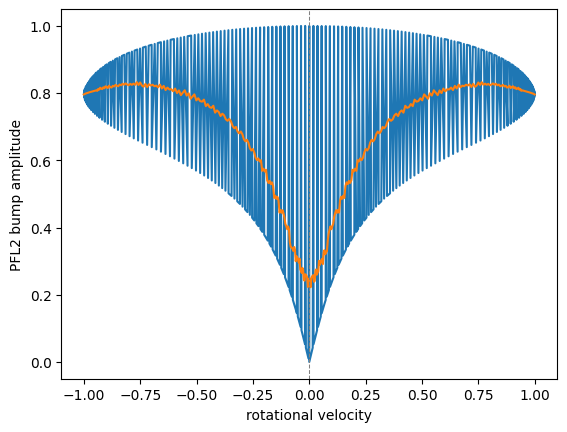

In [6]:
squeezed_PFL2bumpamp = np.squeeze(pfl2_bump_amp[goal_phase==0, S_vals==1, :])
sorted_PFL2bumpamp = squeezed_PFL2bumpamp[sorted_steering_index]

squeezed_pfl2_sum = np.squeeze(pfl2_sum[goal_phase==0, S_vals==1, :])
sorted_PFL2bumpamp_smoothed = savgol_filter(sorted_PFL2bumpamp, 51, 3)

plt.figure()
plt.plot(sorted_steering, sorted_PFL2bumpamp)
plt.plot(sorted_steering_smoothed, sorted_PFL2bumpamp_smoothed)
plt.axvline(0, linestyle = '--', linewidth = 0.75, color = 'gray')

plt.ylabel('PFL2 bump amplitude')
plt.xlabel('rotational velocity')
plt.show()

### Model output vs. directional error (Goal = 0 degrees and S = 1)

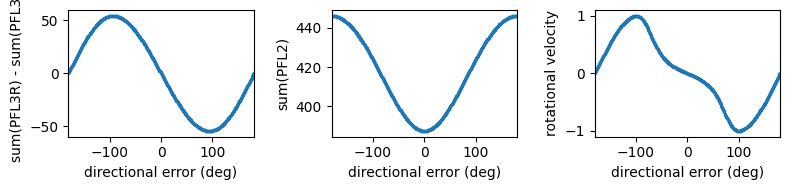

In [7]:
fig = plt.figure(figsize = (8, 2))
fig.patch.set_facecolor('white')
#plt.suptitle(main_cell_type)

ax0 = fig.add_subplot(131)
ax0.plot(squeezed_hd_deg_open_loop, squeezed_pfl3_RL_diff, '.', markersize = 3)
#ax0.title.set_text("Title")
ax0.axes.set_ylabel('sum(PFL3R) - sum(PFL3L)')
ax0.axes.set_xlabel('directional error (deg)')
ax0.set_xlim([-180, 180])

ax1 = fig.add_subplot(132)
ax1.plot(squeezed_hd_deg_open_loop, squeezed_pfl2_sum, '.', markersize = 3)
#ax1.title.set_text("Title")
ax1.axes.set_ylabel('sum(PFL2)')
ax1.axes.set_xlabel('directional error (deg)')
ax1.set_xlim([-180, 180])

ax2 = fig.add_subplot(133)
ax2.plot(squeezed_hd_deg_open_loop, squeezed_steering, '.', markersize = 3)
#ax2.title.set_text("Title")
ax2.axes.set_xlabel('directional error (deg)')
ax2.axes.set_ylabel('rotational velocity')
ax2.set_xlim([-180, 180])

plt.tight_layout()
plt.show()
plt.close()

### PFL input and output for several values of HD and goal = 0 deg (Figure 1)

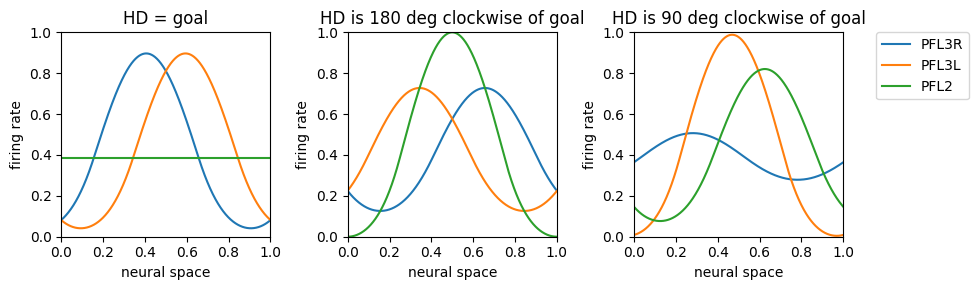

In [8]:
h0 = np.where(hd_deg_open_loop == 0)[1][0]
h90 = np.where(hd_deg_open_loop == 90)[1][0]
h180 = np.where(hd_deg_open_loop == 180)[1][0]
hneg90 = np.where(hd_deg_open_loop == -90)[1][0]
h45 = np.where(hd_deg_open_loop == 45)[1][0]
hneg45 = np.where(hd_deg_open_loop == -45)[1][0]
h135 = np.where(hd_deg_open_loop == 135)[1][0]
hneg135 = np.where(hd_deg_open_loop == -135)[1][0]

p = np.where(goal_phase == 0)[0][0]

# [0,1] represents the horizontal distance across the fan - shaped body, from left to right
dist = np.linspace(0, 1, num_cells) 

fig = plt.figure(figsize = (10, 3))
fig.patch.set_facecolor('white')

ax0 = fig.add_subplot(131)
ax0.plot(dist, np.squeeze(pfl3r[p, s, h0, :]))
ax0.plot(dist, np.squeeze(pfl3l[p, s, h0, :]))
ax0.plot(dist, np.squeeze(pfl2[p, s, h0, :]))
ax0.title.set_text('HD = goal')
ax0.axes.set_xlabel('neural space')
ax0.axes.set_ylabel('firing rate')
ax0.set_xlim([0, 1])
ax0.set_ylim([0, 1])

ax1 = fig.add_subplot(132)
ax1.plot(dist, np.squeeze(pfl3r[p, s, h180, :]))
ax1.plot(dist, np.squeeze(pfl3l[p, s, h180, :]))
ax1.plot(dist, np.squeeze(pfl2[p, s, h180, :]))
ax1.title.set_text('HD is 180 deg clockwise of goal')
ax1.axes.set_xlabel('neural space')
ax1.axes.set_ylabel('firing rate')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

ax2 = fig.add_subplot(133)
ax2.plot(dist, np.squeeze(pfl3r[p, s, h90, :]))
ax2.plot(dist, np.squeeze(pfl3l[p, s, h90, :]))
ax2.plot(dist, np.squeeze(pfl2[p, s, h90, :]))
ax2.title.set_text('HD is 90 deg clockwise of goal')
ax2.axes.set_xlabel('neural space')
ax2.axes.set_ylabel('firing rate')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

legend_list = ['PFL3R','PFL3L','PFL2']
plt.legend(legend_list, bbox_to_anchor=(1.6, 1), loc='upper right', borderaxespad=0)

plt.tight_layout()
plt.show()
plt.close()

### Head direction input to the model

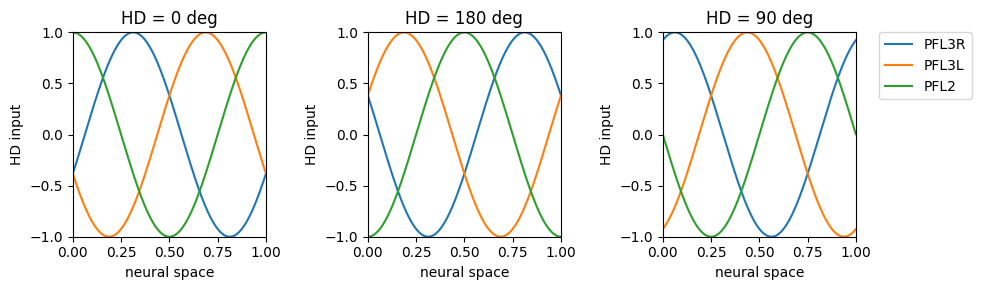

In [9]:
fig = plt.figure(figsize = (9, 3))
fig.patch.set_facecolor('white')

ax0 = fig.add_subplot(131)
ax0.plot(dist, pfl3r_HD_input[h0, :])
ax0.plot(dist, pfl3l_HD_input[h0, :])
ax0.plot(dist, pfl2_HD_input[h0, :])
ax0.title.set_text('HD = 0 deg')
ax0.axes.set_xlabel('neural space')
ax0.axes.set_ylabel('HD input')
ax0.set_xlim([0, 1])
ax0.set_ylim([-1, 1])

ax1 = fig.add_subplot(132)
ax1.plot(dist, pfl3r_HD_input[h180, :])
ax1.plot(dist, pfl3l_HD_input[h180, :])
ax1.plot(dist, pfl2_HD_input[h180, :])
ax1.title.set_text('HD = 180 deg')
ax1.axes.set_xlabel('neural space')
ax1.axes.set_ylabel('HD input')
ax1.set_xlim([0, 1])
ax1.set_ylim([-1, 1])

ax2 = fig.add_subplot(133)
ax2.plot(dist, pfl3r_HD_input[h90, :], label = 'PFL3R')
ax2.plot(dist, pfl3l_HD_input[h90, :], label = 'PFL3L')
ax2.plot(dist, pfl2_HD_input[h90, :], label = 'PFL2')
ax2.title.set_text('HD = 90 deg')
ax2.axes.set_xlabel('neural space')
ax2.axes.set_ylabel('HD input')
ax2.set_xlim([0, 1])
ax2.set_ylim([-1, 1])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.6, 1), loc='upper right', borderaxespad=0)
plt.show()
plt.close()

### PFL model output at different head directions when goal = 0

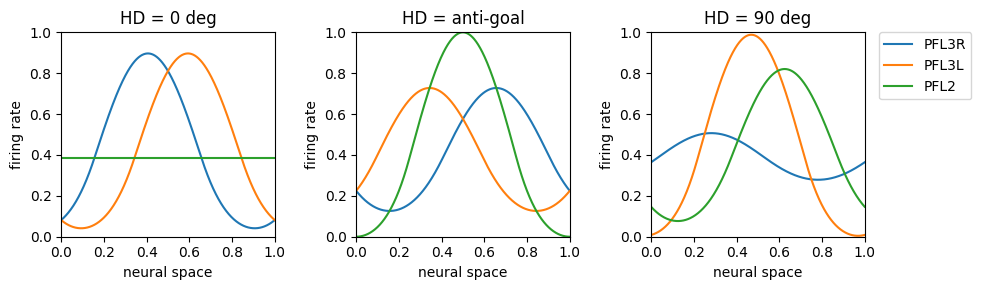

In [10]:
fig = plt.figure(figsize = (9, 3))
fig.patch.set_facecolor('white')

ax0 = fig.add_subplot(131)
ax0.plot(dist, np.squeeze(pfl3r[p, s, h0, :]))
ax0.plot(dist, np.squeeze(pfl3l[p, s, h0, :]))
ax0.plot(dist, np.squeeze(pfl2[p, s, h0, :]))
ax0.title.set_text('HD = 0 deg')
ax0.axes.set_xlabel('neural space')
ax0.axes.set_ylabel('firing rate')
ax0.set_xlim([0, 1])
ax0.set_ylim([0, 1])

ax1 = fig.add_subplot(132)
ax1.plot(dist, np.squeeze(pfl3r[p, s, h180, :]), label = 'PFL3R')
ax1.plot(dist, np.squeeze(pfl3l[p, s, h180, :]), label = 'PFL3L')
ax1.plot(dist, np.squeeze(pfl2[p, s, h180, :]), label = 'PFL2')
ax1.title.set_text('HD = anti-goal')
ax1.axes.set_xlabel('neural space')
ax1.axes.set_ylabel('firing rate')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

ax2 = fig.add_subplot(133)
ax2.plot(dist, np.squeeze(pfl3r[p, s, h90, :]), label = 'PFL3R')
ax2.plot(dist, np.squeeze(pfl3l[p, s, h90, :]), label = 'PFL3L')
ax2.plot(dist, np.squeeze(pfl2[p, s, h90, :]), label = 'PFL2')
ax2.title.set_text('HD = 90 deg')
ax2.axes.set_xlabel('neural space')
ax2.axes.set_ylabel('firing rate')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)

plt.show()
plt.close()

### PFL output and steering output for different values of S (Figure 5)

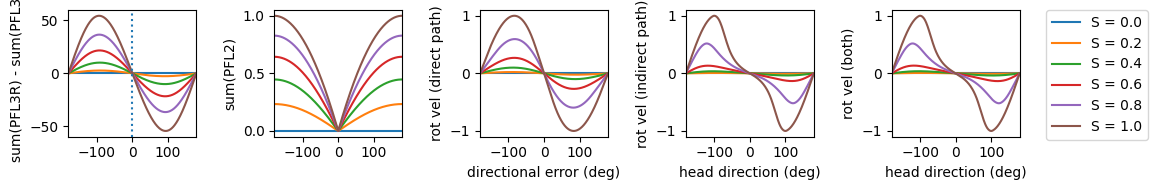

In [11]:
dist = np.linspace(0,1,num_cells) # [0,1] represents the horizontal distance across the fan - shaped body, from left to right

if not pfl3_inhibitory_option:
    p = np.where(goal_phase == 0)[0][0] # get index value where goal phase is 0 deg

if pfl3_inhibitory_option:
    p = np.where(goal_phase == 180)[0][0] # get index value where goal phase is 180 deg

fig = plt.figure(figsize = (12, 2))
fig.patch.set_facecolor('white')
#plt.suptitle(main_cell_type)

ax0 = fig.add_subplot(151)
ax0.plot(hd_deg_open_loop.reshape(np.flip(hd_deg_open_loop.shape)), np.squeeze(pfl3_RL_diff[p,:,:]).T)
#ax0.title.set_text("Title")
ax0.axvline(0, linestyle = ':')
ax0.axes.set_ylabel('sum(PFL3R) - sum(PFL3L)')
ax0.set_xlim([-180, 180])

ax1 = fig.add_subplot(152)
ax1.plot(hd_deg_open_loop.reshape(np.flip(hd_deg_open_loop.shape)), np.squeeze(pfl2_bump_amp[p,:,:]).T)
#ax1.title.set_text("Title")
ax1.axes.set_ylabel('sum(PFL2)')
ax1.set_xlim([-180, 180])

ax2 = fig.add_subplot(153)
ax2.plot(hd_deg_open_loop.reshape(np.flip(hd_deg_open_loop.shape)), np.squeeze(steering_direct[p,:,:]).T)
#ax2.title.set_text("Title")
ax2.axes.set_xlabel('directional error (deg)')
ax2.axes.set_ylabel('rot vel (direct path)')
ax2.set_xlim([-180, 180])

ax3 = fig.add_subplot(154)
ax3.plot(hd_deg_open_loop.reshape(np.flip(hd_deg_open_loop.shape)), np.squeeze(steering_indirect[p,:,:]).T)
#ax3.title.set_text("Title")
ax3.axes.set_xlabel('head direction (deg)')
ax3.axes.set_ylabel('rot vel (indirect path)')
ax3.set_xlim([-180, 180])

ax4 = fig.add_subplot(155)
ax4.plot(hd_deg_open_loop.reshape(np.flip(hd_deg_open_loop.shape)), np.squeeze(steering[p,:,:]).T)
#ax4.title.set_text("Title")
ax4.axes.set_xlabel('head direction (deg)')
ax4.axes.set_ylabel('rot vel (both)')
ax4.set_xlim([-180, 180])

legend_list = [f"S = {current_val:.1f}" for current_val in S_vals]
plt.legend(legend_list, bbox_to_anchor=(2, 1), loc='upper right', borderaxespad=0)
plt.tight_layout()
plt.show()
plt.close()

### PFL2 activity for 4 HD bins, two values of S, and two goal phases (Figure 5)

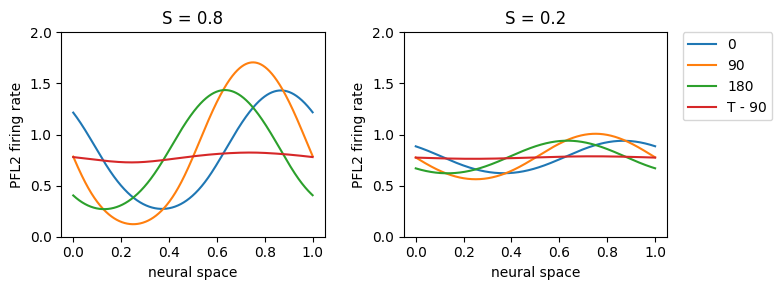

In [12]:
p = np.where(goal_phase == -90)[0][0]
S_ind = np.where(S_vals == 0.8)[0][0]
S_ind_S2 = np.where(S_vals == 0.2)[0][0]

pfl2_copy = np.squeeze(pfl2[p, S_ind, :, :])
pfl2_bin1 = (np.mean(pfl2_copy[h0:h45,:], axis = 0))
pfl2_bin2 = (np.mean(pfl2_copy[h45:h90,:], axis = 0))
pfl2_bin3 = (np.mean(pfl2_copy[h90:h135,:], axis = 0))
pfl2_bin4 = (np.mean(pfl2_copy[h135:h180,:], axis = 0))
pfl2_bin5 = (np.mean(pfl2_copy[1:hneg135,:], axis = 0))
pfl2_bin6 = (np.mean(pfl2_copy[hneg135:hneg90,:], axis = 0))
pfl2_bin7 = (np.mean(pfl2_copy[hneg90:hneg45,:], axis = 0))
pfl2_bin8 = (np.mean(pfl2_copy[hneg45:h0,:], axis = 0))

pfl2_copy_S2 = np.squeeze(pfl2[p, S_ind_S2, :, :])
pfl2_bin1_S2 = (np.mean(pfl2_copy_S2[h0:h45,:], axis = 0))
pfl2_bin2_S2 = (np.mean(pfl2_copy_S2[h45:h90,:], axis = 0))
pfl2_bin3_S2 = (np.mean(pfl2_copy_S2[h90:h135,:], axis = 0))
pfl2_bin4_S2 = (np.mean(pfl2_copy_S2[h135:h180,:], axis = 0))
pfl2_bin5_S2 = (np.mean(pfl2_copy_S2[1:hneg135,:], axis = 0))
pfl2_bin6_S2 = (np.mean(pfl2_copy_S2[hneg135:hneg90,:], axis = 0))
pfl2_bin7_S2 = (np.mean(pfl2_copy_S2[hneg90:hneg45,:], axis = 0))
pfl2_bin8_S2 = (np.mean(pfl2_copy_S2[hneg45:h0,:], axis = 0))

fig = plt.figure(figsize = (7, 3))
fig.patch.set_facecolor('white')

ax0 = fig.add_subplot(121)
ax0.plot(dist, pfl2_bin1 + pfl2_bin8, label = "0")
ax0.plot(dist, pfl2_bin2 + pfl2_bin3, label = "90")
ax0.plot(dist, pfl2_bin4 + pfl2_bin5, label = "180")
ax0.plot(dist, pfl2_bin6 + pfl2_bin7, label = "T - 90")
ax0.title.set_text('S = 0.8')
ax0.axes.set_xlabel('neural space')
ax0.axes.set_ylabel('PFL2 firing rate')
ax0.set_ylim([0, 2])

ax1 = fig.add_subplot(122)
ax1.plot(dist, pfl2_bin1_S2 + pfl2_bin8_S2, label = "0")
ax1.plot(dist, pfl2_bin2_S2 + pfl2_bin3_S2, label = "90")
ax1.plot(dist, pfl2_bin4_S2 + pfl2_bin5_S2, label = "180")
ax1.plot(dist, pfl2_bin6_S2 + pfl2_bin7_S2, label = "T - 90")
ax1.title.set_text('S = 0.2')
ax1.axes.set_xlabel('neural space')
ax1.axes.set_ylabel('PFL2 firing rate')
ax1.set_ylim([0, 2])


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
plt.show()
plt.close()

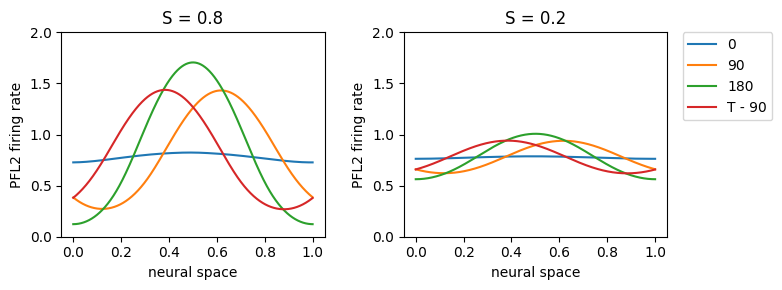

In [13]:
## plot the above for the second goal phase

p = np.where(goal_phase == 0)[0][0]
S_ind = np.where(S_vals == 0.8)[0][0]
S_ind_S2 = np.where(S_vals == 0.2)[0][0]

pfl2_copy = np.squeeze(pfl2[p, S_ind, :, :])
pfl2_bin1 = (np.mean(pfl2_copy[h0:h45,:], axis = 0))
pfl2_bin2 = (np.mean(pfl2_copy[h45:h90,:], axis = 0))
pfl2_bin3 = (np.mean(pfl2_copy[h90:h135,:], axis = 0))
pfl2_bin4 = (np.mean(pfl2_copy[h135:h180,:], axis = 0))
pfl2_bin5 = (np.mean(pfl2_copy[1:hneg135,:], axis = 0))
pfl2_bin6 = (np.mean(pfl2_copy[hneg135:hneg90,:], axis = 0))
pfl2_bin7 = (np.mean(pfl2_copy[hneg90:hneg45,:], axis = 0))
pfl2_bin8 = (np.mean(pfl2_copy[hneg45:h0,:], axis = 0))

pfl2_copy_S2 = np.squeeze(pfl2[p, S_ind_S2, :, :])
pfl2_bin1_S2 = (np.mean(pfl2_copy_S2[h0:h45,:], axis = 0))
pfl2_bin2_S2 = (np.mean(pfl2_copy_S2[h45:h90,:], axis = 0))
pfl2_bin3_S2 = (np.mean(pfl2_copy_S2[h90:h135,:], axis = 0))
pfl2_bin4_S2 = (np.mean(pfl2_copy_S2[h135:h180,:], axis = 0))
pfl2_bin5_S2 = (np.mean(pfl2_copy_S2[1:hneg135,:], axis = 0))
pfl2_bin6_S2 = (np.mean(pfl2_copy_S2[hneg135:hneg90,:], axis = 0))
pfl2_bin7_S2 = (np.mean(pfl2_copy_S2[hneg90:hneg45,:], axis = 0))
pfl2_bin8_S2 = (np.mean(pfl2_copy_S2[hneg45:h0,:], axis = 0))

fig = plt.figure(figsize = (7, 3))
fig.patch.set_facecolor('white')

ax0 = fig.add_subplot(121)
ax0.plot(dist, pfl2_bin1 + pfl2_bin8, label = "0")
ax0.plot(dist, pfl2_bin2 + pfl2_bin3, label = "90")
ax0.plot(dist, pfl2_bin4 + pfl2_bin5, label = "180")
ax0.plot(dist, pfl2_bin6 + pfl2_bin7, label = "T - 90")
ax0.title.set_text('S = 0.8')
ax0.axes.set_xlabel('neural space')
ax0.axes.set_ylabel('PFL2 firing rate')
ax0.set_ylim([0, 2])

ax1 = fig.add_subplot(122)
ax1.plot(dist, pfl2_bin1_S2 + pfl2_bin8_S2, label = "0")
ax1.plot(dist, pfl2_bin2_S2 + pfl2_bin3_S2, label = "90")
ax1.plot(dist, pfl2_bin4_S2 + pfl2_bin5_S2, label = "180")
ax1.plot(dist, pfl2_bin6_S2 + pfl2_bin7_S2, label = "T - 90")
ax1.title.set_text('S = 0.2')
ax1.axes.set_xlabel('neural space')
ax1.axes.set_ylabel('PFL2 firing rate')
ax1.set_ylim([0, 2])


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
plt.show()
plt.close()

### Find the system's stable fixed point for different goal phases (EDF)

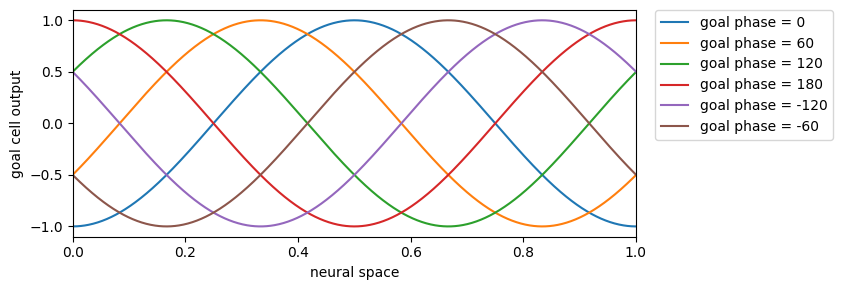

In [14]:
p0 = np.where(goal_phase == 0)[0][0]
p60 = np.where(goal_phase == 60)[0][0]
p120 = np.where(goal_phase == 120)[0][0]
p180 = np.where(goal_phase == 180)[0][0]
pneg120 = np.where(goal_phase == - 120)[0][0]
pneg60 = np.where(goal_phase == - 60)[0][0]

fig = plt.figure(figsize = (9, 3))
fig.patch.set_facecolor('white')

for P in [0, 60, 120, 180,  -120,  -60]:
    
    goal_cells = np.squeeze(A * (np.cos(np.deg2rad( -hd_prefs + P - offset_deg))))
    plt.plot(dist, goal_cells)

plt.xlabel('neural space')
plt.ylabel('goal cell output')
plt.xlim([0, 1])

legend_list = [f"goal phase = {current_val:.0f}" for current_val in [0, 60, 120, 180,  -120,  -60]]
plt.legend(legend_list, bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)

plt.tight_layout()
plt.show()

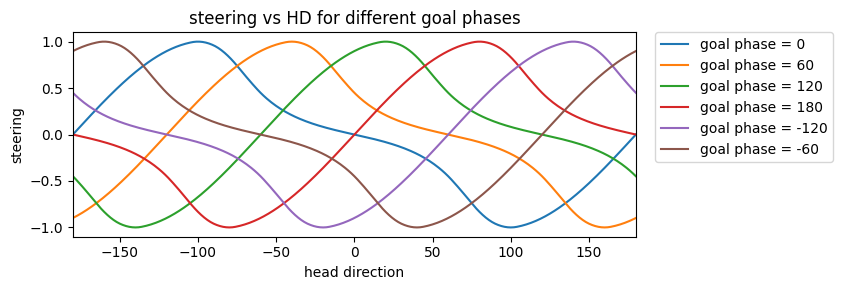

In [15]:
s = np.where(S_vals == 1)[0][0] # get index value for S = 1

fig = plt.figure(figsize = (9, 3))
fig.patch.set_facecolor('white')

plt.plot(squeezed_hd_deg_open_loop, np.squeeze(steering[p0,s,:]))
plt.plot(squeezed_hd_deg_open_loop, np.squeeze(steering[p60,s,:]))
plt.plot(squeezed_hd_deg_open_loop, np.squeeze(steering[p120,s,:]))
plt.plot(squeezed_hd_deg_open_loop, np.squeeze(steering[p180,s,:]))
plt.plot(squeezed_hd_deg_open_loop, np.squeeze(steering[pneg120,s,:]))
plt.plot(squeezed_hd_deg_open_loop, np.squeeze(steering[pneg60,s,:]))

plt.xlabel('head direction')
plt.ylabel('steering')
plt.xlim([-180, 180])

legend_list = [f"goal phase = {current_val:.0f}" for current_val in [0, 60, 120, 180,  -120,  -60]]
plt.legend(legend_list, bbox_to_anchor=(1.35, 1), loc='upper right', borderaxespad=0)

plt.title('steering vs HD for different goal phases')
plt.tight_layout()
plt.show()

In [16]:
stableFPfwd = np.zeros((num_goals, num_scalars)) # HD where rotational velocity becomes negative when searching clockwise from the maximum rotational velocity
stableFPrev = np.zeros((num_goals, num_scalars)) # HD where rotational velocity becomes positive when searching counterclockwise from the minimum rotational velocity

for p in range(num_goals):
    for s in range(num_scalars):

        max_loc = np.argmax(steering[p,s,:])
        max_val = steering[p,s,:][max_loc]
        min_loc = np.argmin(steering[p,s,:])
        min_val = steering[p,s,:][min_loc]

        stableFPfwd[p,s] = 0
        stableFPrev[p,s] = 0

        if max_val > 0:
            rolled_steering = np.roll(steering[p,s,:], -max_loc)
            rolled_zero_point = np.where(rolled_steering <= 0)[0][0]
            zero_point = (rolled_zero_point + max_loc) % len(rolled_steering)
            stableFPfwd[p,s] = squeezed_hd_deg_open_loop[zero_point]

        if min_val < 0:
            rolled_steering = np.roll(steering[p,s,:], -min_loc)
            rolled_zero_point = np.where(rolled_steering >= 0)[0][-1]
            zero_point = (rolled_zero_point + min_loc) % len(rolled_steering)
            stableFPrev[p,s] = squeezed_hd_deg_open_loop[zero_point]

stableFPfwd[0] = [elem - 360 if elem > 90 else elem for elem in stableFPfwd[0]]
stableFPrev[0] = [elem - 360 if elem > 90 else elem for elem in stableFPrev[0]]
stableFPfwd[-1] = [elem + 360 if elem < -90 else elem for elem in stableFPfwd[-1]]
stableFPrev[-1] = [elem + 360 if elem < -90 else elem for elem in stableFPrev[-1]]

stableFP = (stableFPfwd + stableFPrev)/2 # average the two estimates of the stable fixed point


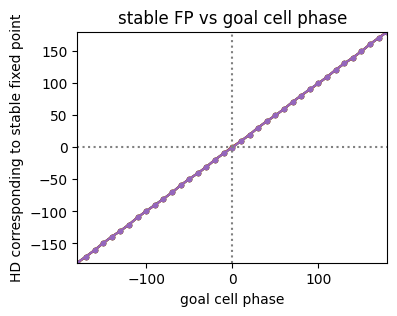

In [17]:
fig = plt.figure(figsize = (4, 3))
fig.patch.set_facecolor('white')

plt.plot(goal_phase, stableFP[:, np.where(S_vals > 0)[0]], '-o', markersize = 3)

plt.axvline(0, color = 'gray', linestyle = ':')
plt.axhline(0, color = 'gray', linestyle = ':')

plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.xlabel('goal cell phase')
plt.ylabel('HD corresponding to stable fixed point')
plt.title('stable FP vs goal cell phase')
# legend(legendCell,'Location','northwest')

plt.show()

### Simulate changes in HD over time, for different values of the PFL scalar (Figure 5)

In [18]:
k = 200 # factor relating PFL activity to steering

if not pfl3_inhibitory_option:
    p = np.where(goal_phase == 0)[0][0]

if pfl3_inhibitory_option:
    p = np.where(goal_phase == 180)[0][0]
    
num_timepoints = 1000
fs = 10
fpass = 2
timebase = np.linspace(0, num_timepoints/fs, num_timepoints)
noise_level = 10 # orig 10
num_runs = 50

steering_history = np.zeros((num_runs,num_scalars,num_timepoints)) # rotational velocity over time, for each value of S
hd_deg_history = np.zeros((num_runs,num_scalars,num_timepoints)) # head direction over time, for each value of S
steering_history_direct = np.zeros((num_runs,num_scalars,num_timepoints)) # variant using only the direct pathway
hd_deg_history_direct = np.zeros((num_runs,num_scalars,num_timepoints))
steering_history_indirect = np.zeros((num_runs,num_scalars,num_timepoints)) # variant using only the indirect pathway
hd_deg_history_indirect = np.zeros((num_runs,num_scalars,num_timepoints))
rho = np.zeros((num_runs,num_scalars)) # consistency of head direction, for each value of S
pfl2_bump_amp_range = np.zeros((1,num_scalars)) # how much pfl2_bump_amp changes as a function of HD, for each value of S

for r in range(num_runs):

    random_noise_gaussian = np.random.normal(size = (num_timepoints, 1))
    random_noise_filtered = butter_lowpass_filter(random_noise_gaussian, fpass, fs) # low-pass filter
    random_noise = noise_level * zscore(random_noise_filtered) # rescale

    for s in range(num_scalars):

        hd_deg_history[r, s, 0] = 180 # starting head direction, in degrees
        steering_history[r, s, 0] = 0 # starting steering command

        for t in range(1, num_timepoints):
            current_hd = hd_deg_history[r,s,t - 1]
            h = np.argmin(np.abs(wrap_to_180(hd_deg_open_loop - current_hd)))
            steering_history[r,s,t] = k*steering[p,s,h] + random_noise[t][0] # updating steering command
            hd_deg_history[r,s,t] = wrap_to_180(hd_deg_history[r, s, t - 1] + steering_history[r,s,t]) # update head direction

        rho[r,s] = 1 - circvar(np.deg2rad(hd_deg_history[r,s,:]), high = np.pi, low = -np.pi) # consistency of HD (rho) is defined as 1  -  cir_var(HD)
        pfl2_bump_amp_range[0, s] = np.max(pfl2_bump_amp[p,s,:]) - np.min(pfl2_bump_amp[p,s,:])
        
        hd_deg_history_direct[r,s,0] = 180 # now run the variant using only the direct pathway
        steering_history_direct[r,s,0] = 0
            
        for t in range(1, num_timepoints):
            current_hd = hd_deg_history_direct[r,s,t - 1]
            h = np.argmin(np.abs(wrap_to_180(hd_deg_open_loop - current_hd)))
            steering_history_direct[r,s,t] = k*steering_direct[p,s,h] + random_noise[t][0] # updating steering command
            hd_deg_history_direct[r,s,t] = wrap_to_180(hd_deg_history_direct[r, s, t - 1] + steering_history_direct[r,s,t]) # update head direction

        hd_deg_history_indirect[r, s,0] = 180 # now run the variant using only the indirect pathway
        steering_history_indirect[r,s,0] = 0
            
        for t in range(1, num_timepoints):
            current_hd = hd_deg_history_indirect[r,s,t - 1]
            h = np.argmin(np.abs(wrap_to_180(hd_deg_open_loop - current_hd)))
            steering_history_indirect[r,s,t] = k*steering_indirect[p,s,h] + random_noise[t][0] # updating steering command
            hd_deg_history_indirect[r,s,t] = wrap_to_180(hd_deg_history_indirect[r, s, t - 1] + steering_history_indirect[r,s,t]) # update head direction

### Error in the direction steered

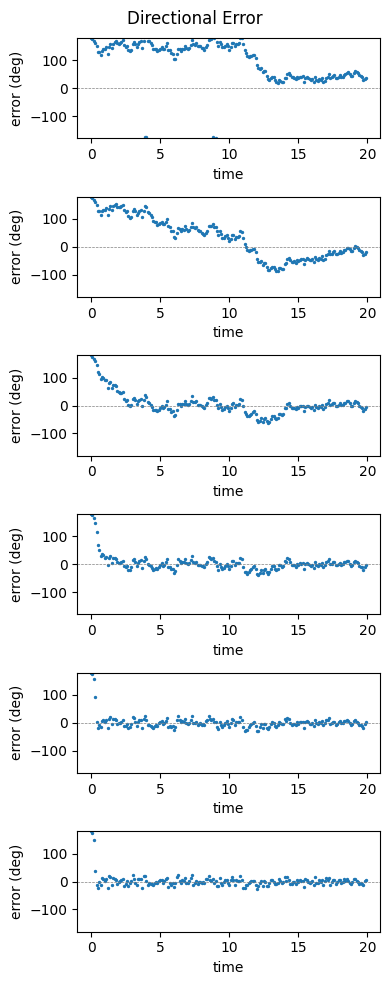

In [19]:
fig_axes = []

fig = plt.figure(figsize = (4, 10))
fig.patch.set_facecolor('white')

r = 10

for axnum in range(num_scalars):

    current_axes = fig.add_subplot(num_scalars, 1, axnum + 1)
    current_axes.scatter(timebase[0:200], np.squeeze(hd_deg_history[r, axnum, 0:200]), s = 2)
    current_axes.axhline(0, linestyle = '--', linewidth = 0.5, color = 'gray')
    current_axes.set_ylim([-180, 180])
    current_axes.axes.set_xlabel('time')
    current_axes.axes.set_ylabel('error (deg)')

    fig_axes.append(current_axes)

fig.suptitle('Directional Error')
plt.tight_layout()
plt.show()

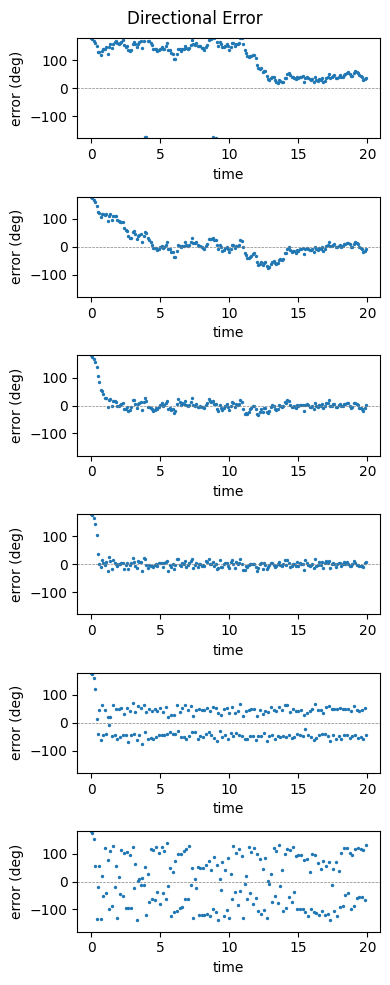

In [20]:
fig_axes = []

fig = plt.figure(figsize = (4, 10))
fig.patch.set_facecolor('white')

for axnum in range(num_scalars):

    current_axes = fig.add_subplot(num_scalars, 1, axnum + 1)
    current_axes.scatter(timebase[0:200], np.squeeze(hd_deg_history_direct[r, axnum, 0:200]), s = 2)
    current_axes.axhline(0, linestyle = '--', linewidth = 0.5, color = 'gray')
    current_axes.set_ylim([-180, 180])
    current_axes.axes.set_xlabel('time')
    current_axes.axes.set_ylabel('error (deg)')

    fig_axes.append(current_axes)

fig.suptitle('Directional Error')
plt.tight_layout()
plt.show()

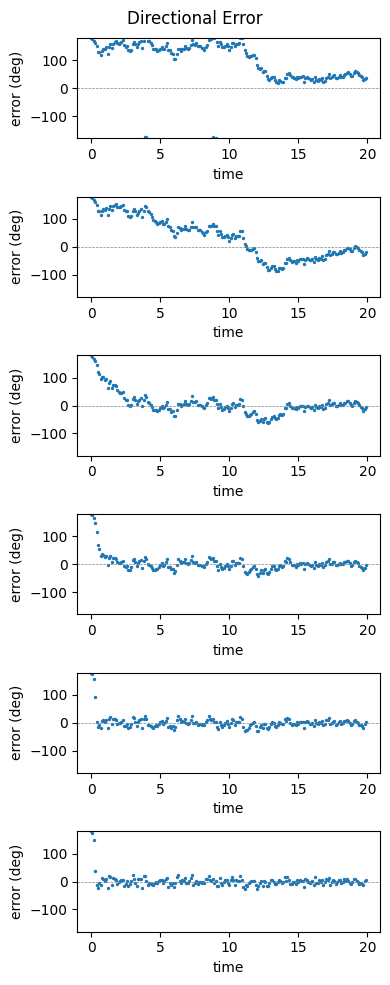

In [21]:
fig_axes = []

fig = plt.figure(figsize = (4, 10))
fig.patch.set_facecolor('white')
#plt.suptitle(main_cell_type)

for axnum in range(num_scalars):

    current_axes = fig.add_subplot(num_scalars, 1, axnum + 1)
    current_axes.scatter(timebase[0:200], np.squeeze(hd_deg_history_indirect[r, axnum, 0:200]), s = 2)
    current_axes.axhline(0, linestyle = '--', linewidth = 0.5, color = 'gray')
    current_axes.set_ylim([-180, 180])
    current_axes.axes.set_xlabel('time')
    current_axes.axes.set_ylabel('error (deg)')

    fig_axes.append(current_axes)

fig.suptitle('Directional Error')
plt.tight_layout()
plt.show()

### Nonlinearity

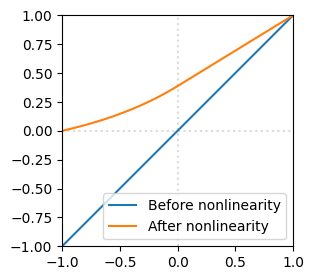

In [22]:
before_nonlinearity = np.linspace(-1, 1, 100)
before_nonlinearity = np.vstack((before_nonlinearity, before_nonlinearity))
after_nonlinearity = nonlinearity(before_nonlinearity)

plt.figure(figsize = (4, 3))
plt.axvline(0, color = 'xkcd:light gray', linestyle = ':')
plt.axhline(0, color = 'xkcd:light gray', linestyle = ':')
plt.plot(before_nonlinearity[0], before_nonlinearity[0], label = 'Before nonlinearity')
plt.plot(before_nonlinearity[0], after_nonlinearity[0], label = 'After nonlinearity')
plt.axis('scaled')
plt.legend()
plt.xlim([ -1, 1])
plt.ylim([-1, 1])
plt.show()

### Tuning curves

In [23]:
p = np.where(goal_phase == 0)[0][0] # get index value where goal phase = 0 deg
s = np.where(S_vals == 1)[0][0] # get index value where S = 1

pfl2_dist_to_goal = np.zeros((1, num_cells)) # matrix for storing the distance between preferred HD and goal, for all combinations of goal phase and preferred HD
pfl3r_dist_to_goal = np.zeros((1, num_cells))
pfl3l_dist_to_goal = np.zeros((1, num_cells))

for n in range(num_cells):
    pfl2_dist_to_goal[:, n] = np.rad2deg(abs(circ_dist(np.deg2rad(pfl2_HD_prefs[:, n]), np.deg2rad(goal_phase[p])))) # compute absolute circular distance between preferred HD and goal, in degrees
    pfl3r_dist_to_goal[:, n] = np.rad2deg(abs(circ_dist(np.deg2rad(pfl3r_HD_prefs[:, n]), np.deg2rad(goal_phase[p]))))
    pfl3l_dist_to_goal[:, n] = np.rad2deg(abs(circ_dist(np.deg2rad(pfl3l_HD_prefs[:, n]), np.deg2rad(goal_phase[p]))))

pfl2_dist_to_goal = (pfl2_dist_to_goal + np.roll(pfl2_dist_to_goal,1) + np.roll(pfl2_dist_to_goal, - 1))/3 # boxcar smoothing over a 3 - sample window (this generally makes the mininum unique, even if N is large)
pfl3r_dist_to_goal = (pfl3r_dist_to_goal + np.roll(pfl3r_dist_to_goal,1) + np.roll(pfl3r_dist_to_goal, - 1))/3 
pfl3l_dist_to_goal = (pfl3l_dist_to_goal + np.roll(pfl3l_dist_to_goal,1) + np.roll(pfl3l_dist_to_goal, - 1))/3

pfl2_tuning_centered = (pfl2[p,s]) # extract tuning curves for the goal phase and amplitude we are focusing on
pfl2_tuning_centered = np.squeeze(pfl2_tuning_centered) # remove dimensions equal to 1
minloc = np.argmin(pfl2_dist_to_goal) # find the index of the cell whose preferred HD is closest to the goal (i.e., minimizing the distance to the goal)

pfl2_tuning_centered = np.roll(pfl2_tuning_centered,round(num_cells/2 - minloc)) # shift cell order so that the cell in the middle of the array is the one whose preferred HD is closest to the goal
pfl3r_tuning_centered = (pfl3r[p,s])
pfl3r_tuning_centered = np.squeeze(pfl3r_tuning_centered)
minloc = np.argmin(pfl3r_dist_to_goal)

pfl3r_tuning_centered = np.roll(pfl3r_tuning_centered, round(num_cells/2 - minloc))
pfl3l_tuning_centered = (pfl3l[p,s])
pfl3l_tuning_centered = np.squeeze(pfl3l_tuning_centered)
minloc = np.argmin(pfl3l_dist_to_goal)
pfl3l_tuning_centered = np.roll(pfl3l_tuning_centered,round(num_cells/2 - minloc))

for n in range(num_cells):
    maxloc = np.argmax(pfl2_tuning_centered[:,n]) # find the index corresponding to the max of this tuning curve
    pfl2_tuning_centered[:,n] = np.roll(pfl2_tuning_centered[:,n],181 - maxloc) # horizontally shift this tuning curve so that it's centered on the peak
    maxloc = np.argmax(pfl3r_tuning_centered[:,n]) 
    pfl3r_tuning_centered[:,n] = np.roll(pfl3r_tuning_centered[:,n],181 - maxloc)
    maxloc = np.argmax(pfl3l_tuning_centered[:,n]) 
    pfl3l_tuning_centered[:,n] = np.roll(pfl3l_tuning_centered[:,n],181 - maxloc)


In [24]:
def plot_centered_averaged_tuning_curves(tuning_curves, hd_deg_open_loop, ylabel_txt = 'activity'):
    mean_tuning_curves = np.zeros((len(hd_deg_open_loop[0, :]), 5)) # matrix for storing averaged tuning curves

    if tuning_curves.shape[1] == 12: # 12 cells per type
        mean_tuning_curves[:, 0] = np.mean(tuning_curves[:,1:2], 1) # bin together cells with similar preferred HD, and average their tuning curves
        mean_tuning_curves[:, 1] = np.mean(tuning_curves[:,3:5], 1)
        mean_tuning_curves[:, 2] = np.mean(tuning_curves[:,6:7], 1)
        mean_tuning_curves[:, 3] = np.mean(tuning_curves[:,8:10], 1)
        mean_tuning_curves[:, 4] = np.mean(tuning_curves[:,11:12], 1)

    if tuning_curves.shape[1] == 1000: # 1000 cells per type
        mean_tuning_curves[:, 0] = np.mean(tuning_curves[:,1:199], 1)
        mean_tuning_curves[:, 1] = np.mean(tuning_curves[:,200:399], 1)
        mean_tuning_curves[:, 2] = np.mean(tuning_curves[:,400:600], 1)
        mean_tuning_curves[:, 3] = np.mean(tuning_curves[:,601:800], 1)
        mean_tuning_curves[:, 4] = np.mean(tuning_curves[:,801:1000], 1)

    mean_tuning_curves = mean_tuning_curves - np.min(mean_tuning_curves, 0)
    
    miny = np.min(mean_tuning_curves)
    maxy = np.max(mean_tuning_curves)

    fig = plt.figure(figsize = (14, 3))
    fig.patch.set_facecolor('white')
    
    ax0 = fig.add_subplot(151)
    ax0.plot(squeezed_hd_deg_open_loop, mean_tuning_curves[:, 0])
    ax0.axes.set_ylabel(ylabel_txt)
    ax0.axes.set_xlabel('HD - goal (deg)')
    ax0.set_xlim([-180, 180])
    ax0.set_ylim([miny, maxy])
    ax0.title.set_text('-144 deg')
    
    ax1 = fig.add_subplot(152)
    ax1.plot(squeezed_hd_deg_open_loop, mean_tuning_curves[:, 1])
    ax1.title.set_text('-72 degrees')
    ax1.axes.set_xlabel('HD - goal (deg)')
    ax1.axes.set_ylabel('sum(PFL2)')
    ax1.set_xlim([-180, 180])
    ax1.set_ylim([miny, maxy])
    
    ax2 = fig.add_subplot(153)
    ax2.plot(squeezed_hd_deg_open_loop, mean_tuning_curves[:, 2])
    ax2.title.set_text('0 degrees')
    ax2.axes.set_xlabel('HD - goal (deg)')
    ax2.axes.set_ylabel('rot vel (direct path)')
    ax2.set_xlim([-180, 180])
    ax2.set_ylim([miny, maxy])
    
    ax3 = fig.add_subplot(154)
    ax3.plot(squeezed_hd_deg_open_loop, mean_tuning_curves[:, 3])
    ax3.title.set_text('72 degrees')
    ax3.axes.set_xlabel('HD - goal (deg)')
    ax3.axes.set_ylabel('rot vel (indirect path)')
    ax3.set_xlim([-180, 180])
    ax3.set_ylim([miny, maxy])
    
    ax4 = fig.add_subplot(155)
    ax4.plot(squeezed_hd_deg_open_loop, mean_tuning_curves[:, 4])
    ax4.title.set_text('144 degrees')
    ax4.axes.set_xlabel('HD - goal (deg)')
    ax4.axes.set_ylabel('rot vel (both)')
    ax4.set_xlim([-180, 180])
    ax4.set_ylim([miny, maxy])
    
    plt.tight_layout()
    plt.show()
    plt.close()

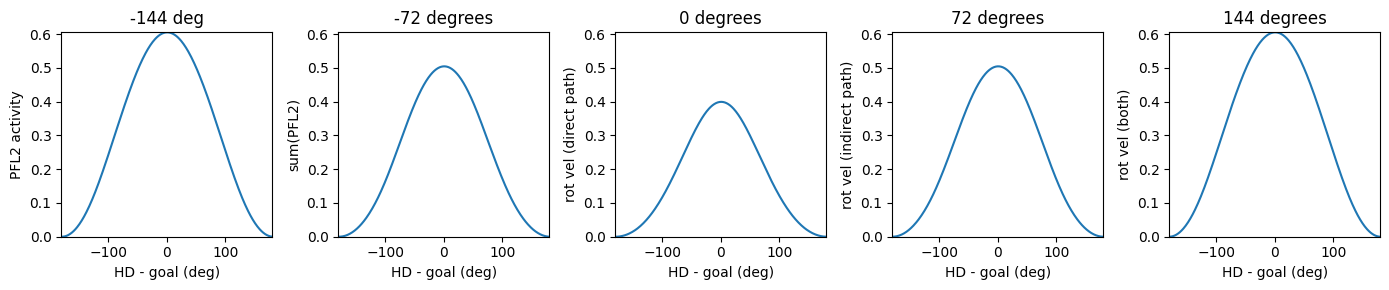

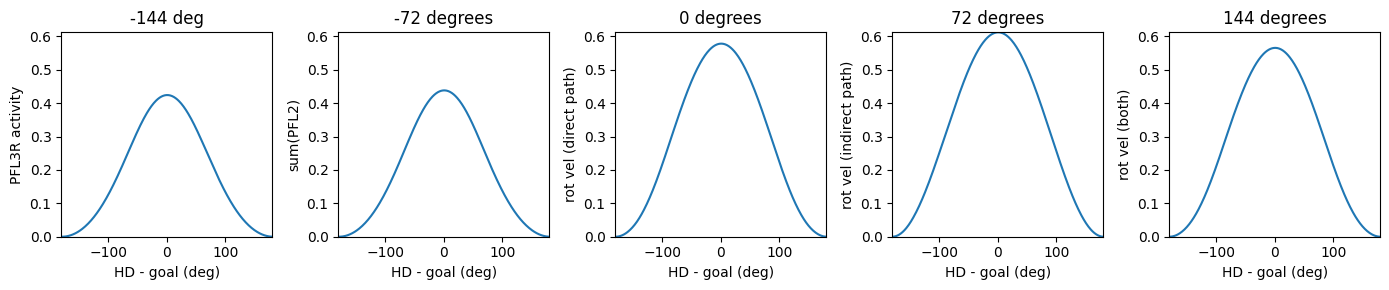

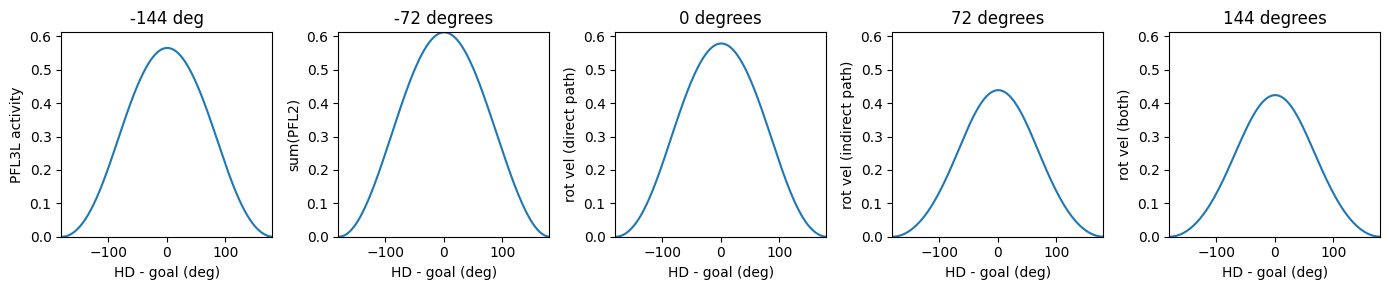

In [25]:
plot_centered_averaged_tuning_curves(pfl2_tuning_centered,hd_deg_open_loop, ylabel_txt = 'PFL2 activity')
plot_centered_averaged_tuning_curves(pfl3r_tuning_centered,hd_deg_open_loop, ylabel_txt = 'PFL3R activity')
plot_centered_averaged_tuning_curves(pfl3l_tuning_centered,hd_deg_open_loop, ylabel_txt = 'PFL3L activity')
